In [1]:
pip install torch


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
%%capture
!kaggle datasets download -d vitvhong/uplink-sum-rate
!unzip uplink-sum-rate.zip -d ./uplink
%cd uplink

In [3]:
import numpy as np
import torch
from torch_geometric.loader import  DataLoader
from torch_geometric.data import HeteroData, Data, Dataset, Batch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, ELU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6
import scipy.io
from torch_geometric.nn import HeteroConv, SAGEConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

In [4]:
train_layouts = 5000
test_layouts = 100

In [5]:
import scipy.io
import numpy as np

# Danh sách tên các tệp .mat mà bạn muốn tải
file_names = ['cf_train_50_20_sum.mat', 'cf_train_70_20_sum.mat', 'cf_train_100_20_sum.mat']

# Khởi tạo danh sách để lưu trữ dữ liệu từ mỗi tệp
data_list = []

# Lặp qua từng tệp để tải dữ liệu
for file_name in file_names:
    # Tải dữ liệu từ tệp
    data = scipy.io.loadmat(file_name)

    # Lấy mẫu từ các biến
    beta_samples = data['betas'][:train_layouts]
    direct_samples = data['directs'][:train_layouts]
    cross_samples = data['corsses'].transpose(0, 2, 1)[:train_layouts]

    # Lưu trữ dữ liệu vào từ điển
    data_list.append({
        'beta': beta_samples,
        'direct': direct_samples,
        'cross': cross_samples
    })

# Bây giờ, data_list chứa dữ liệu từ tất cả các tệp, bạn có thể truy cập từng tệp như sau:
for i, file_data in enumerate(data_list):
    print(f"File {i + 1}:")
    print("Beta shape:", file_data['beta'].shape)
    print("Direct shape:", file_data['direct'].shape)
    print("Cross shape:", file_data['cross'].shape)
    print()


File 1:
Beta shape: (5000, 50, 20)
Direct shape: (5000, 20)
Cross shape: (5000, 20, 20)

File 2:
Beta shape: (5000, 70, 20)
Direct shape: (5000, 20)
Cross shape: (5000, 20, 20)

File 3:
Beta shape: (5000, 100, 20)
Direct shape: (5000, 20)
Cross shape: (5000, 20, 20)



In [6]:
def normalize_data(train_data,test_data):
    train_std = np.std(train_data)
    norm_train = (train_data)/train_std
    norm_test = (test_data)/train_std
    return norm_train, norm_test
norm_train_losses_20_50, _ = normalize_data(data_list[0]['beta']**(1/2), 0 )
norm_train_losses_20_70, _ = normalize_data(data_list[1]['beta']**(1/2), 0 )
norm_train_losses_20_100, _ = normalize_data(data_list[2]['beta']**(1/2), 0 )

In [7]:
class PCDataset(Dataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = norm_losses
        self.direct = torch.tensor(direct, dtype=torch.float)
        self.cross = torch.tensor(cross, dtype=torch.float)
        self.KM = KM
        self.get_cg()
        self.process()

    def build_graph(self, idx):
        edge_feature = self.norm_losses[idx, :, :].reshape((self.KM[0] * self.KM[1], 1), order='F')
        edge_feature = np.concatenate((edge_feature, np.ones_like(edge_feature)), axis=-1)
        edge_feature = torch.tensor(edge_feature, dtype=torch.float)

        edge_index = torch.tensor(self.adj, dtype=torch.long).t().contiguous()
        edge_index_t = torch.tensor(self.adj_t, dtype=torch.long).t().contiguous()
        ue_features = torch.ones((self.KM[0], 1))
        ap_features = torch.ones((self.KM[1], 1))

        data = HeteroData()
        data['UE'].x = ue_features
        data['AP'].x = ap_features
        data['UE', 'com-by', 'AP'].edge_index = edge_index
        data['UE', 'com-by', 'AP'].edge_attr = edge_feature
        data['AP', 'com', 'UE'].edge_index = edge_index_t
        data['AP', 'com', 'UE'].edge_attr = edge_feature

        return data

    def get_cg(self):
        self.adj = []
        self.adj_t = []
        for i in range(self.KM[0]):
            for j in range(self.KM[1]):
                self.adj.append([i, j])
                self.adj_t.append([j, i])

    def process(self):
        self.graph_list = [self.build_graph(i) for i in range(len(self.direct))]

    def __len__(self):
        return len(self.direct)

    def __getitem__(self, index):
        return self.graph_list[index], self.direct[index], self.cross[index]

In [8]:
def collate(samples):
    '''Pytorch Geometric collate function'''
    graphs, direct, cross = map(list, zip(*samples))
    batched_graph = Batch.from_data_list(graphs)
    return batched_graph, torch.stack(direct), torch.stack(cross)

In [11]:
train_data_20_50 = PCDataset(norm_train_losses_20_50, data_list[0]['direct'], data_list[0]['cross'], (20, 50))
train_data_20_70 = PCDataset(norm_train_losses_20_70, data_list[1]['direct'], data_list[1]['cross'], (20, 70))
train_data_20_100 = PCDataset(norm_train_losses_20_100, data_list[2]['direct'], data_list[2]['cross'], (20, 100))

In [12]:
batch_size = 64
train_loader_20_50 = DataLoader(train_data_20_50, batch_size, shuffle=True, collate_fn=collate)
train_loader_20_70 = DataLoader(train_data_20_70, batch_size, shuffle=True, collate_fn=collate)
train_loader_20_100 = DataLoader(train_data_20_100, batch_size, shuffle=True, collate_fn=collate)

In [13]:
def sum_rate_loss(allocs, directlink_channel_losses, crosslink_channel_losses, test_mode = False):
    SINRs_numerators = allocs * directlink_channel_losses**2
    SINRs_denominators = torch.squeeze(torch.matmul(crosslink_channel_losses, torch.unsqueeze(allocs, axis=-1))) + directlink_channel_losses
    SINRs = SINRs_numerators / SINRs_denominators
    rates = torch.log2(1 + SINRs)
    min_rate = torch.sum(rates, dim = 1) # take sum
    if test_mode:
        return min_rate
    else:
        return -torch.mean(min_rate)

In [14]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class EdgeConv(MessagePassing):
    def __init__(self, input_dim, node_dim, **kwargs):
        super(EdgeConv, self).__init__(aggr='mean')  # mean aggregation
        self.lin = MLP([input_dim, 32])
        self.res_lin = Lin(node_dim, 32)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):

        feat_src, feat_dst = x


        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)


        return self.bn(out + self.res_lin(feat_dst))

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        return self.lin(out)

    def update(self, aggr_out):
        return aggr_out



In [15]:
class RGCN(nn.Module):
    def __init__(self):
        super(RGCN, self).__init__()
        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(4, 1),
            ('AP', 'com', 'UE'): EdgeConv(4, 1)
        }, aggr='sum')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32)
        }, aggr='sum')

        self.conv3 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32)
        }, aggr='sum')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])

    def forward(self,x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


In [16]:
model = RGCN()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [17]:
def train_model(epoch, model, optimizer, train_loader):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (data, d_train, c_train) in enumerate(train_loader):
        K = d_train.shape[-1]
        n = len(data['UE'].x)
        bs = len(data['UE'].x) // K

        optimizer.zero_grad()

        # Lấy các đặc trưng nút từ từ điển x_dict
        user_feats = data['AP'].x
        item_feats = data['UE'].x
        node_features = {'AP': user_feats, 'UE': item_feats}

        # Truyền qua mô hình, bao gồm cả edge_attr_dict
        output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

        # Tính loss và thực hiện backpropagation
        loss = sum_rate_loss(output, d_train, c_train)
        loss.backward()

        loss_all += loss.item() * bs
        optimizer.step()

    return loss_all / len(train_loader.dataset)

def test_model(loader, model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (data, d_test, c_test) in loader:
            K = d_test.shape[-1]
            n = len(data['UE'].x)
            bs = len(data['UE'].x) // K

            # Lấy các đặc trưng nút từ từ điển x_dict
            user_feats = data['AP'].x
            item_feats = data['UE'].x
            # Create a dictionary for node features
            node_features = {'AP': user_feats, 'UE': item_feats}

            output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

            # Tính loss
            loss = sum_rate_loss(output, d_test, c_test)
            correct += loss.item() * bs

    return correct / len(loader.dataset)

In [68]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_50, model)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model, optimizer, train_loader_20_50)
    scheduler.step()


Epoch 000, Train Rate: -15.2676
Epoch 001, Train Rate: -17.7747
Epoch 002, Train Rate: -18.6737
Epoch 003, Train Rate: -19.0248
Epoch 004, Train Rate: -19.1862
Epoch 005, Train Rate: -19.2051
Epoch 006, Train Rate: -19.3771
Epoch 007, Train Rate: -19.2011
Epoch 008, Train Rate: -19.5046
Epoch 009, Train Rate: -19.6171
Epoch 010, Train Rate: -19.5314
Epoch 011, Train Rate: -19.5151
Epoch 012, Train Rate: -19.5578
Epoch 013, Train Rate: -19.7240
Epoch 014, Train Rate: -19.7143
Epoch 015, Train Rate: -19.6873
Epoch 016, Train Rate: -19.6916
Epoch 017, Train Rate: -19.6984
Epoch 018, Train Rate: -19.6965
Epoch 019, Train Rate: -19.8176
Epoch 020, Train Rate: -19.7588
Epoch 021, Train Rate: -19.7274
Epoch 022, Train Rate: -19.7585
Epoch 023, Train Rate: -19.6787
Epoch 024, Train Rate: -19.7200
Epoch 025, Train Rate: -19.7242
Epoch 026, Train Rate: -19.8361
Epoch 027, Train Rate: -19.8437
Epoch 028, Train Rate: -19.7943
Epoch 029, Train Rate: -19.8733


In [69]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_70, model)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model, optimizer, train_loader_20_70)
    scheduler.step()


Epoch 000, Train Rate: -22.5547
Epoch 001, Train Rate: -22.5335
Epoch 002, Train Rate: -22.6214
Epoch 003, Train Rate: -22.4475
Epoch 004, Train Rate: -22.5737
Epoch 005, Train Rate: -22.2954
Epoch 006, Train Rate: -22.6069
Epoch 007, Train Rate: -22.5758
Epoch 008, Train Rate: -22.6409
Epoch 009, Train Rate: -22.1312
Epoch 010, Train Rate: -22.6640
Epoch 011, Train Rate: -22.6562
Epoch 012, Train Rate: -22.5299
Epoch 013, Train Rate: -22.5517
Epoch 014, Train Rate: -22.6060
Epoch 015, Train Rate: -22.6069
Epoch 016, Train Rate: -22.6580
Epoch 017, Train Rate: -22.6619
Epoch 018, Train Rate: -22.6485
Epoch 019, Train Rate: -22.6438
Epoch 020, Train Rate: -22.5908
Epoch 021, Train Rate: -22.5492
Epoch 022, Train Rate: -22.6014
Epoch 023, Train Rate: -22.6611
Epoch 024, Train Rate: -22.4440
Epoch 025, Train Rate: -22.6220
Epoch 026, Train Rate: -22.6797
Epoch 027, Train Rate: -22.6372
Epoch 028, Train Rate: -22.6417
Epoch 029, Train Rate: -22.6576


In [70]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_100, model)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model, optimizer, train_loader_20_100)
    scheduler.step()


Epoch 000, Train Rate: -26.8742
Epoch 001, Train Rate: -26.9186
Epoch 002, Train Rate: -26.9069
Epoch 003, Train Rate: -26.9099
Epoch 004, Train Rate: -26.6501
Epoch 005, Train Rate: -26.9471
Epoch 006, Train Rate: -26.8374
Epoch 007, Train Rate: -26.8418
Epoch 008, Train Rate: -26.8817
Epoch 009, Train Rate: -26.6296
Epoch 010, Train Rate: -26.4688
Epoch 011, Train Rate: -26.9548
Epoch 012, Train Rate: -26.9365
Epoch 013, Train Rate: -26.9352
Epoch 014, Train Rate: -26.8385
Epoch 015, Train Rate: -26.8637
Epoch 016, Train Rate: -26.9652
Epoch 017, Train Rate: -26.8786
Epoch 018, Train Rate: -26.9107
Epoch 019, Train Rate: -26.9629
Epoch 020, Train Rate: -26.8659
Epoch 021, Train Rate: -26.9567
Epoch 022, Train Rate: -26.9678
Epoch 023, Train Rate: -26.6597
Epoch 024, Train Rate: -26.9673
Epoch 025, Train Rate: -26.9382
Epoch 026, Train Rate: -26.8088
Epoch 027, Train Rate: -26.9691
Epoch 028, Train Rate: -26.8914
Epoch 029, Train Rate: -26.8031


#HQGNN

In [18]:
pip install pennylane

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
dev = qml.device('default.qubit', wires=n_qubits)


In [32]:
n_layers_circuit_X = 2
def circuit_X_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_X):
        circuit_X_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X = { "layer_weights": (n_layers_circuit_X, n_qubits)}

In [33]:
n_layers_circuit_Z = 2
def circuit_Z_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_Z):
        circuit_Z_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z = { "layer_weights": (n_layers_circuit_Z, n_qubits)}

In [34]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer, self).__init__(aggr='mean')  # mean aggregation
        self.lin_res = qml.qnn.TorchLayer(circuit_Z, weight_shapes_circuit_Z)
        self.lin_qml = qml.qnn.TorchLayer(circuit_X, weight_shapes_circuit_X)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits)
        self.bn = BN(2 ** n_qubits)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(feat_dst)
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [35]:
class RGCN_Hybrid_mid(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid, self).__init__()
        out_dim = 2**n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(1, 1, edge_dim,)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
         }, aggr='mean')


        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [36]:
model_qml_mid = RGCN_Hybrid_mid().to()

optimizer_qml_mid = torch.optim.Adam(model_qml_mid.parameters(), lr=5e-4)
scheduler_qml_mid = torch.optim.lr_scheduler.StepLR(optimizer_qml_mid, step_size=10, gamma=0.6)

In [44]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_50, model_qml_mid)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid, optimizer_qml_mid, train_loader_20_50)
    scheduler_qml_mid.step()

Epoch 000, Train Rate: -15.2465
Epoch 001, Train Rate: -14.0635
Epoch 002, Train Rate: -18.1200
Epoch 003, Train Rate: -17.6055
Epoch 004, Train Rate: -17.7269
Epoch 005, Train Rate: -17.6738
Epoch 006, Train Rate: -18.1934
Epoch 007, Train Rate: -17.6460
Epoch 008, Train Rate: -17.6428
Epoch 009, Train Rate: -18.9694
Epoch 010, Train Rate: -18.6345
Epoch 011, Train Rate: -19.2697
Epoch 012, Train Rate: -19.4483
Epoch 013, Train Rate: -19.5805
Epoch 014, Train Rate: -18.7222
Epoch 015, Train Rate: -19.5346
Epoch 016, Train Rate: -19.4180
Epoch 017, Train Rate: -19.6110
Epoch 018, Train Rate: -19.1441
Epoch 019, Train Rate: -18.8771
Epoch 020, Train Rate: -19.4340
Epoch 021, Train Rate: -19.8237
Epoch 022, Train Rate: -19.8287
Epoch 023, Train Rate: -19.1317
Epoch 024, Train Rate: -19.6096
Epoch 025, Train Rate: -19.8781
Epoch 026, Train Rate: -18.9821
Epoch 027, Train Rate: -19.6552
Epoch 028, Train Rate: -19.6263
Epoch 029, Train Rate: -19.6026


In [45]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_70, model_qml_mid)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid, optimizer_qml_mid, train_loader_20_70)
    scheduler_qml_mid.step()

Epoch 000, Train Rate: -21.5009
Epoch 001, Train Rate: -22.1921
Epoch 002, Train Rate: -22.3912
Epoch 003, Train Rate: -22.5952
Epoch 004, Train Rate: -22.5073
Epoch 005, Train Rate: -21.7981
Epoch 006, Train Rate: -22.5048
Epoch 007, Train Rate: -22.6221
Epoch 008, Train Rate: -21.3352
Epoch 009, Train Rate: -22.3449
Epoch 010, Train Rate: -22.1410
Epoch 011, Train Rate: -22.2879
Epoch 012, Train Rate: -22.6470
Epoch 013, Train Rate: -22.6650
Epoch 014, Train Rate: -22.6517
Epoch 015, Train Rate: -22.4335
Epoch 016, Train Rate: -22.4407
Epoch 017, Train Rate: -22.6475
Epoch 018, Train Rate: -22.6497
Epoch 019, Train Rate: -22.6815
Epoch 020, Train Rate: -22.6274
Epoch 021, Train Rate: -22.6882
Epoch 022, Train Rate: -22.4420
Epoch 023, Train Rate: -22.6783
Epoch 024, Train Rate: -22.6487
Epoch 025, Train Rate: -22.6450
Epoch 026, Train Rate: -22.6804
Epoch 027, Train Rate: -22.6648
Epoch 028, Train Rate: -22.6652
Epoch 029, Train Rate: -22.6022


In [46]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_100, model_qml_mid)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid, optimizer_qml_mid, train_loader_20_100)
    scheduler_qml_mid.step()

Epoch 000, Train Rate: -26.6860
Epoch 001, Train Rate: -26.8595
Epoch 002, Train Rate: -26.8676
Epoch 003, Train Rate: -26.9056
Epoch 004, Train Rate: -26.8745
Epoch 005, Train Rate: -26.8974
Epoch 006, Train Rate: -26.9400
Epoch 007, Train Rate: -26.9269
Epoch 008, Train Rate: -26.4633
Epoch 009, Train Rate: -26.9141
Epoch 010, Train Rate: -26.8979
Epoch 011, Train Rate: -26.8826
Epoch 012, Train Rate: -26.9238
Epoch 013, Train Rate: -26.8841
Epoch 014, Train Rate: -26.9017
Epoch 015, Train Rate: -26.8751
Epoch 016, Train Rate: -26.9274
Epoch 017, Train Rate: -26.8368
Epoch 018, Train Rate: -26.9092
Epoch 019, Train Rate: -26.7682
Epoch 020, Train Rate: -26.9421
Epoch 021, Train Rate: -26.9499
Epoch 022, Train Rate: -26.9627
Epoch 023, Train Rate: -26.9514
Epoch 024, Train Rate: -26.9584
Epoch 025, Train Rate: -26.9158
Epoch 026, Train Rate: -26.8985
Epoch 027, Train Rate: -26.9127
Epoch 028, Train Rate: -26.9399
Epoch 029, Train Rate: -26.9676


In [ ]:
# torch.save(model.state_dict(), 'model_sum.pth')
# torch.save(model_qml_mid.state_dict(), 'model_amplitude_sum.pth')

In [40]:
model.load_state_dict(torch.load('model_sum.pth'))
model_qml_mid.load_state_dict(torch.load('model_amplitude_sum.pth'))

C:\Users\pc230\AppData\Local\Temp\ipykernel_6528\2942611935.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_sum.pth'))
C:\Users\p

<All keys matched successfully>

In [57]:
opt_20 = []
qgnn_20 = []
gnn_20 = []
all_one_rates_20 = []
rand_20 = []
for i in range(30,101,10):
  open_file = 'cf_test_' + str(i) + '_20_sum.mat'
  data = scipy.io.loadmat(open_file)
  beta = data['betas']
  direct = data['directs']
  cross = data['corsses'].transpose(0,2,1)
  opti = data['R_cf_opt_sum']
  opt_20.append(np.mean(opti))
  _, norm_losses = normalize_data(beta**(1/2), beta**(1/2))
  data = PCDataset(norm_losses, direct, cross, (20, i))
  loader = DataLoader(data, 100, shuffle=False, collate_fn=collate)
  for (data, d_test, c_test) in loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model_qml_mid(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output1 = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    full = torch.ones_like(output)
    qgnn_rates = -sum_rate_loss(output, d_test, c_test).detach().numpy()
    gnn_rates = -sum_rate_loss(output1, d_test, c_test).detach().numpy()
    all_one = -sum_rate_loss(full, d_test, c_test).detach().numpy()
    rand = torch.rand_like(output)
    random_rates = -sum_rate_loss(rand, d_test, c_test).detach().numpy()
  gnn_20.append(gnn_rates)
  qgnn_20.append(qgnn_rates)
  all_one_rates_20.append(all_one)
  rand_20.append(random_rates)


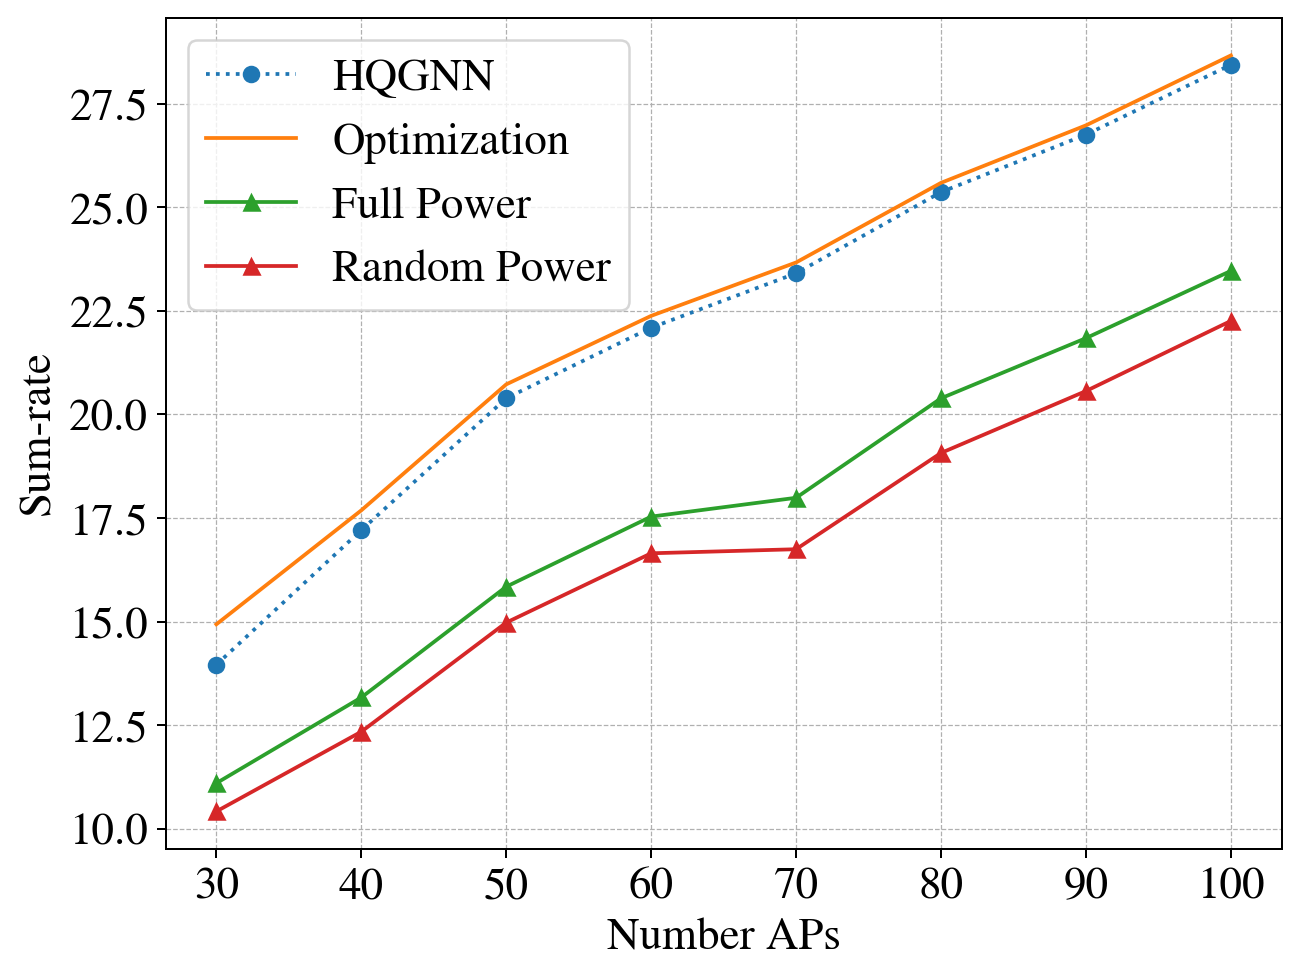

In [59]:
import matplotlib.pyplot as plt


plt.rc("text", usetex=False)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8, 6), dpi=180)
x_values = list(range(30, 101, 10))

ax.plot(x_values, qgnn_20, label='HQGNN', linestyle=':', marker='o')  
#ax.plot(x_values, gnn_20, label='GNN', linestyle='--')
ax.plot(x_values, opt_20, label='Optimization', linestyle='-') 
ax.plot(x_values, all_one_rates_20, label='Full Power', linestyle='-', marker='^')
ax.plot(x_values, rand_20, label='Random Power', linestyle='-', marker='^')

ax.set_xlabel('Number APs')
ax.set_ylabel('Sum-rate')


ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)



x1, x2, y1, y2 = 79, 81, 25, 26


# axins = ax.inset_axes([0.75, 0.2, 0.2, 0.2])


# axins.plot(x_values, qgnn_20, label='HQGNN', linestyle=':', marker='o')
# #axins.plot(x_values, gnn_20, label='GNN', linestyle='--')
# axins.plot(x_values, opt_20, label='Optimization', linestyle='-')
# axins.plot(x_values, all_one_rates_20, label='Maximum Power', linestyle='-', marker='^')


# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)


# ax.indicate_inset_zoom(axins, edgecolor="black")
plt.savefig("sum_rate.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [55]:
opt_20 = []
qgnn_20 = []
gnn_20 = []
all_one_rates_20 = []
rand_20 = []
for i in range(30,101,10):
  open_file = 'cf_test_' + str(i) + '_20_sum.mat'
  data = scipy.io.loadmat(open_file)
  beta = data['betas']
  direct = data['directs']
  cross = data['corsses'].transpose(0,2,1)
  opti = data['R_cf_opt_sum']
  opt_20.append(np.mean(opti))
  _, norm_losses = normalize_data(beta**(1/2), beta**(1/2))
  data = PCDataset(norm_losses, direct, cross, (20, i))
  loader = DataLoader(data, 100, shuffle=False, collate_fn=collate)
  for (data, d_test, c_test) in loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model_qml_mid_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output1 = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    full = torch.ones_like(output)
    qgnn_rates = -sum_rate_loss(output, d_test, c_test).detach().numpy()
    gnn_rates = -sum_rate_loss(output1, d_test, c_test).detach().numpy()
    all_one = -sum_rate_loss(full, d_test, c_test).detach().numpy()
    rand = torch.rand_like(output)
    random_rates = -sum_rate_loss(rand, d_test, c_test).detach().numpy()
  gnn_20.append(gnn_rates)
  qgnn_20.append(qgnn_rates)
  all_one_rates_20.append(all_one)
  rand_20.append(random_rates)


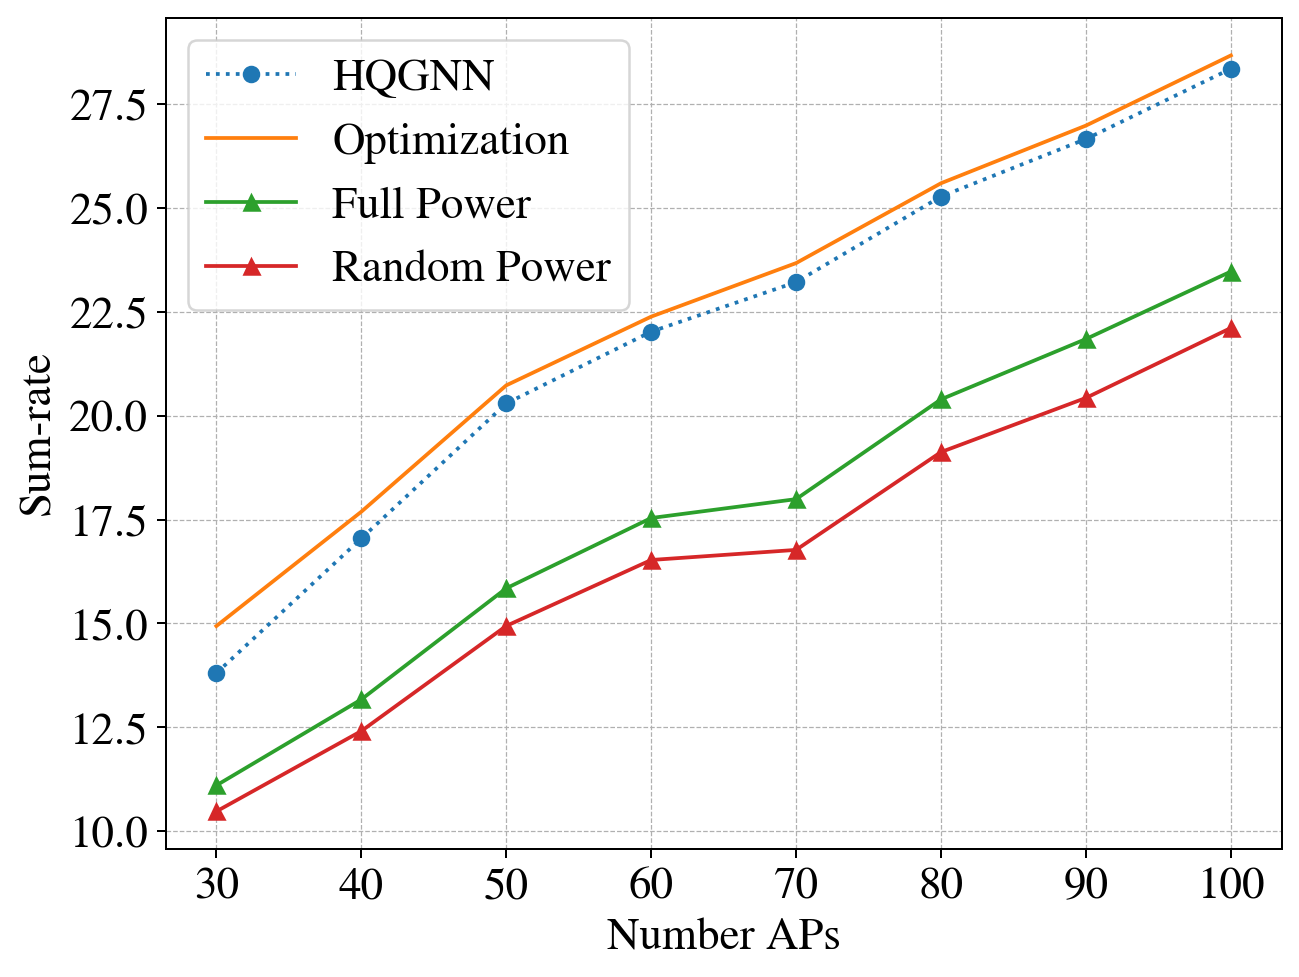

In [56]:
import matplotlib.pyplot as plt


plt.rc("text", usetex=False)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8, 6), dpi=180)
x_values = list(range(30, 101, 10))

ax.plot(x_values, qgnn_20, label='HQGNN', linestyle=':', marker='o')  
#ax.plot(x_values, gnn_20, label='GNN', linestyle='--')
ax.plot(x_values, opt_20, label='Optimization', linestyle='-') 
ax.plot(x_values, all_one_rates_20, label='Full Power', linestyle='-', marker='^')
ax.plot(x_values, rand_20, label='Random Power', linestyle='-', marker='^')

ax.set_xlabel('Number APs')
ax.set_ylabel('Sum-rate')


ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)



x1, x2, y1, y2 = 79, 81, 25, 26


# axins = ax.inset_axes([0.75, 0.2, 0.2, 0.2])


# axins.plot(x_values, qgnn_20, label='HQGNN', linestyle=':', marker='o')
# #axins.plot(x_values, gnn_20, label='GNN', linestyle='--')
# axins.plot(x_values, opt_20, label='Optimization', linestyle='-')
# axins.plot(x_values, all_one_rates_20, label='Maximum Power', linestyle='-', marker='^')


# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)


# ax.indicate_inset_zoom(axins, edgecolor="black")
plt.savefig("sum_rate.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [43]:
open_file = 'cf_test_30_6_sum.mat'
data = scipy.io.loadmat(open_file)
beta = data['betas']
direct = data['directs']
cross = data['corsses'].transpose(0,2,1)
opti = data['R_cf_opt_sum']
_, norm_losses = normalize_data(beta**(1/2), beta**(1/2))
data = PCDataset(norm_losses, direct, cross, (6, 30))
loader = DataLoader(data, 200, shuffle=False, collate_fn=collate)
for (data, d_test, c_test) in loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model_qml_mid(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output1 = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    full = torch.ones_like(output)
    random = torch.rand_like(output)
    qgnn_rates = -sum_rate_loss(output, d_test, c_test).detach().numpy()
    gnn_rates = -sum_rate_loss(output1, d_test, c_test).detach().numpy()
    all_one = -sum_rate_loss(full, d_test, c_test).detach().numpy()
    rand_rates = -sum_rate_loss(random, d_test, c_test).detach().numpy()

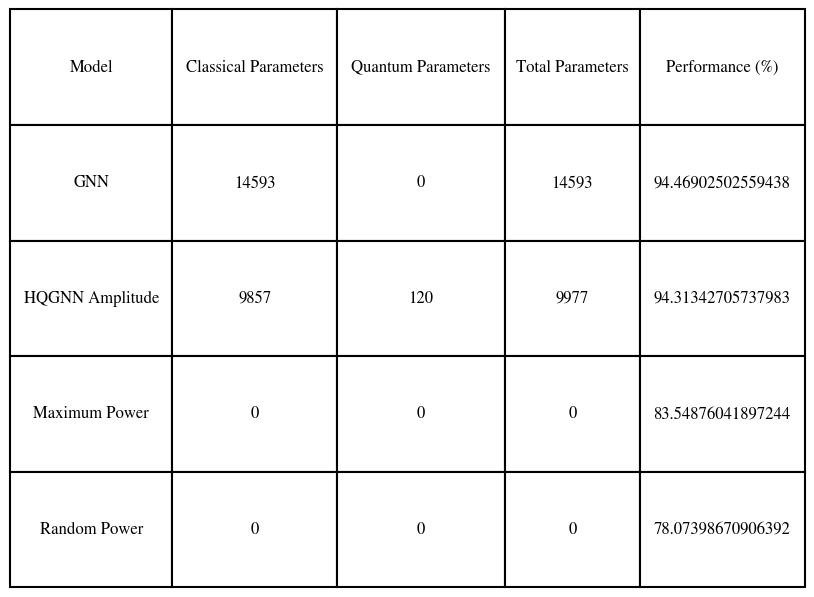

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  
            quantum_params += param.numel()
        else:  
            classical_params += param.numel()
    return quantum_params, classical_params

# Models to analyze
models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_mid,
    # "HQGNN Angle": model_qml_mid_angle,
}

# Compute parameter counts
params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}

# Performance metrics
avg_gnn_test_rates = np.mean(gnn_rates)
avg_gnn_test_rates_amplitude = np.mean(qgnn_rates)
# avg_gnn_test_rates_angle = np.mean(angle_qgnn_20)
opt_rates = np.mean(opti)
all_one_rates = np.mean(all_one)
rand_rates = np.mean(rand_rates)

performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    # "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
    "Maximum Power": (all_one_rates / opt_rates) * 100,
    "Random Power": (rand_rates / opt_rates) * 100
}

# Combine data into a DataFrame
data = {
    "Model": ["GNN", "HQGNN Amplitude", "Maximum Power", "Random Power"],
    "Classical Parameters": [
        params_count["GNN"][1], 
        params_count["HQGNN Amplitude"][1], 
        # params_count["HQGNN Angle"][1], 
        0, 
        0
    ],
    "Quantum Parameters": [
        params_count["GNN"][0], 
        params_count["HQGNN Amplitude"][0], 
        # params_count["HQGNN Angle"][0], 
        0, 
        0
    ],
    "Total Parameters": [
        params_count["GNN"][0] + params_count["GNN"][1], 
        params_count["HQGNN Amplitude"][0] + params_count["HQGNN Amplitude"][1], 
        # params_count["HQGNN Angle"][0] + params_count["HQGNN Angle"][1], 
        0, 
        0
    ],
    "Performance (%)": [
        performance_percentages["GNN"], 
        performance_percentages["HQGNN Amplitude"], 
        # performance_percentages["HQGNN Angle"], 
        performance_percentages["Maximum Power"], 
        performance_percentages["Random Power"]
    ],
}

params_df = pd.DataFrame(data)

# Visualize the data as a table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5)
    cell.set_height(0.3)
    cell.set_width(0.25)

# Save and display the table
plt.savefig("model_parameters_table_combined.png", dpi=300, bbox_inches='tight')
plt.show()


# HQGNN Angle

In [22]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
dev = qml.device('default.qubit', wires=n_qubits)


In [23]:
n_layers_circuit_X2 = 4
def circuit_X2_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])
@qml.qnode(dev, interface='torch')
def circuit_X2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_X2):
        circuit_X2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X2 = { "layer_weights": (n_layers_circuit_X2, n_qubits)}

In [24]:
n_layers_circuit_Z2 = 4
def circuit_Z2_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_Z2):
        circuit_Z2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z2 = { "layer_weights": (n_layers_circuit_Z2, n_qubits)}

In [25]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer_angle(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, out_dim, **kwargs):
        super(Q_layer_angle, self).__init__(aggr='mean')  
        self.lin_res = qml.qnn.TorchLayer(circuit_X2, weight_shapes_circuit_X2)
        self.lin_qml = qml.qnn.TorchLayer(circuit_Z2, weight_shapes_circuit_Z2)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, out_dim)
        self.linear = nn.Linear(dst_dim, n_qubits)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(self.linear(feat_dst))
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [26]:
class RGCN_Hybrid_mid_angle(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid_angle, self).__init__()
        out_dim = n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(1, 1, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(1, 1, edge_dim,out_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
             ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [27]:
model_qml_mid_angle = RGCN_Hybrid_mid_angle().to()

optimizer_qml_mid_angle = torch.optim.Adam(model_qml_mid_angle.parameters(), lr=5e-4)
scheduler_qml_mid_angle = torch.optim.lr_scheduler.StepLR(optimizer_qml_mid_angle, step_size=10, gamma=0.4)
trainable_params = sum(p.numel() for p in model_qml_mid_angle.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3271


In [28]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_50, model_qml_mid_angle)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid_angle, optimizer_qml_mid_angle, train_loader_20_50)
    scheduler_qml_mid_angle.step()

Epoch 000, Train Rate: -15.1907
Epoch 001, Train Rate: -16.1858
Epoch 002, Train Rate: -19.1742
Epoch 003, Train Rate: -19.4252
Epoch 004, Train Rate: -19.5630
Epoch 005, Train Rate: -19.2464
Epoch 006, Train Rate: -19.5422
Epoch 007, Train Rate: -19.7138
Epoch 008, Train Rate: -19.1024
Epoch 009, Train Rate: -19.3928
Epoch 010, Train Rate: -19.4831
Epoch 011, Train Rate: -19.8148
Epoch 012, Train Rate: -19.8224
Epoch 013, Train Rate: -19.8314
Epoch 014, Train Rate: -19.8392
Epoch 015, Train Rate: -19.8063
Epoch 016, Train Rate: -19.4800
Epoch 017, Train Rate: -19.8223
Epoch 018, Train Rate: -19.0568
Epoch 019, Train Rate: -19.8456
Epoch 020, Train Rate: -19.7158
Epoch 021, Train Rate: -19.8778
Epoch 022, Train Rate: -19.8692
Epoch 023, Train Rate: -19.8625
Epoch 024, Train Rate: -19.6498
Epoch 025, Train Rate: -19.8863
Epoch 026, Train Rate: -19.8946
Epoch 027, Train Rate: -19.8945
Epoch 028, Train Rate: -19.9039
Epoch 029, Train Rate: -19.7528


In [29]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_70, model_qml_mid_angle)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid_angle, optimizer_qml_mid_angle, train_loader_20_70)
    scheduler_qml_mid_angle.step()

Epoch 000, Train Rate: -22.4521
Epoch 001, Train Rate: -22.5913
Epoch 002, Train Rate: -22.6027
Epoch 003, Train Rate: -22.5470
Epoch 004, Train Rate: -22.6140
Epoch 005, Train Rate: -22.6117
Epoch 006, Train Rate: -22.6207
Epoch 007, Train Rate: -22.6143
Epoch 008, Train Rate: -22.6176
Epoch 009, Train Rate: -22.6089
Epoch 010, Train Rate: -22.6297
Epoch 011, Train Rate: -22.6221
Epoch 012, Train Rate: -22.6136
Epoch 013, Train Rate: -22.6372
Epoch 014, Train Rate: -22.6383
Epoch 015, Train Rate: -22.6195
Epoch 016, Train Rate: -22.6346
Epoch 017, Train Rate: -22.6325
Epoch 018, Train Rate: -22.6329
Epoch 019, Train Rate: -22.6231
Epoch 020, Train Rate: -22.6380
Epoch 021, Train Rate: -22.6373
Epoch 022, Train Rate: -22.6413
Epoch 023, Train Rate: -22.6333
Epoch 024, Train Rate: -22.6384
Epoch 025, Train Rate: -22.6413
Epoch 026, Train Rate: -22.6395
Epoch 027, Train Rate: -22.6299
Epoch 028, Train Rate: -22.6366
Epoch 029, Train Rate: -22.6381


In [30]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_100, model_qml_mid_angle)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid_angle, optimizer_qml_mid_angle, train_loader_20_100)
    scheduler_qml_mid_angle.step()

Epoch 000, Train Rate: -26.8294
Epoch 001, Train Rate: -26.8070
Epoch 002, Train Rate: -26.8206
Epoch 003, Train Rate: -26.8252
Epoch 004, Train Rate: -26.8230
Epoch 005, Train Rate: -26.8159
Epoch 006, Train Rate: -26.8202
Epoch 007, Train Rate: -26.8181
Epoch 008, Train Rate: -26.8292
Epoch 009, Train Rate: -26.8346
Epoch 010, Train Rate: -26.8184
Epoch 011, Train Rate: -26.8377
Epoch 012, Train Rate: -26.8386
Epoch 013, Train Rate: -26.8328
Epoch 014, Train Rate: -26.8350
Epoch 015, Train Rate: -26.8445
Epoch 016, Train Rate: -26.8339
Epoch 017, Train Rate: -26.8308
Epoch 018, Train Rate: -26.8414
Epoch 019, Train Rate: -26.8276
Epoch 020, Train Rate: -26.8403
Epoch 021, Train Rate: -26.8388
Epoch 022, Train Rate: -26.8397
Epoch 023, Train Rate: -26.8414
Epoch 024, Train Rate: -26.8354
Epoch 025, Train Rate: -26.8307
Epoch 026, Train Rate: -26.8356
Epoch 027, Train Rate: -26.8460
Epoch 028, Train Rate: -26.8412
Epoch 029, Train Rate: -26.8421


In [49]:
torch.save(model_qml_mid_angle.state_dict(), 'model_angle_sum.pth')

In [ ]:
# model.load_state_dict(torch.load('model_sum.pth'))
# model_qml_mid.load_state_dict(torch.load('model_amp_sum.pth'))

In [ ]:
angle_qgnn_20 = []
opt_20 = []
all_one_rates_20 = []
random_rates = []
for i in range(30,101,10):
  open_file = str(i) + '_20.mat'
  data = scipy.io.loadmat(open_file)
  beta = data['betas']
  direct = data['directs']
  cross = data['corsses'].transpose(0,2,1)
  opti = data['R_cf_opt_sum']
  opt_20.append(np.mean(opti))
  _, norm_losses = normalize_data(beta**(1/2), beta**(1/2))
  data = PCDataset(norm_losses, direct, cross, (20, i))
  loader = DataLoader(data, 100, shuffle=False, collate_fn=collate)
  for (data, d_test, c_test) in loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model_qml_mid_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    full = torch.ones_like(output)
    random = torch.rand_like(output)
    qgnn_rates = -sum_rate_loss(output, d_test, c_test).detach().numpy()
    all_one = -sum_rate_loss(full, d_test, c_test).detach().numpy()
    rand_rates = -sum_rate_loss(random, d_test, c_test).detach().numpy()
    
  
  angle_qgnn_20.append(qgnn_rates)
  all_one_rates_20.append(all_one)
  random_rates.append(rand_rates)

In [45]:
open_file = 'cf_test_30_6_sum.mat'
data = scipy.io.loadmat(open_file)
beta = data['betas']
direct = data['directs']
cross = data['corsses'].transpose(0,2,1)
opti = data['R_cf_opt_sum']
_, norm_losses = normalize_data(beta**(1/2), beta**(1/2))
data = PCDataset(norm_losses, direct, cross, (6, 30))
loader = DataLoader(data, 200, shuffle=False, collate_fn=collate)
for (data, d_test, c_test) in loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model_qml_mid(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output1 = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output2 = model_qml_mid_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    full = torch.ones_like(output)
    random = torch.rand_like(output)
    qgnn_rates = -sum_rate_loss(output, d_test, c_test).detach().numpy()
    angle_rates = -sum_rate_loss(output2, d_test, c_test).detach().numpy()
    gnn_rates = -sum_rate_loss(output1, d_test, c_test).detach().numpy()
    all_one = -sum_rate_loss(full, d_test, c_test).detach().numpy()
    rand_rates = -sum_rate_loss(random, d_test, c_test).detach().numpy()

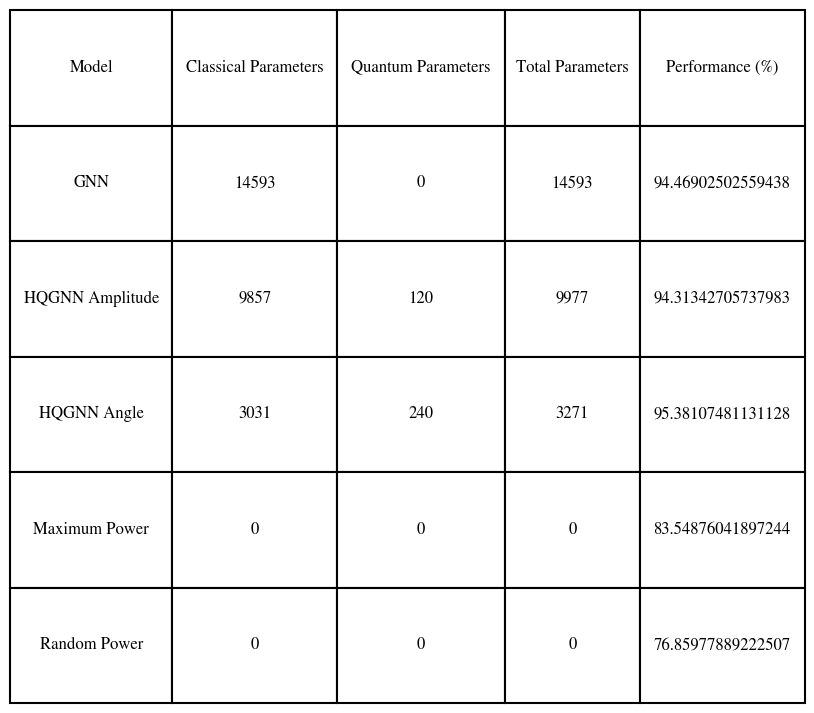

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  
            quantum_params += param.numel()
        else:  
            classical_params += param.numel()
    return quantum_params, classical_params

# Models to analyze
models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_mid,
    "HQGNN Angle": model_qml_mid_angle,
}

# Compute parameter counts
params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}

# Performance metrics
avg_gnn_test_rates = np.mean(gnn_rates)
avg_gnn_test_rates_amplitude = np.mean(qgnn_rates)
avg_gnn_test_rates_angle = np.mean(angle_rates)
opt_rates = np.mean(opti)
all_one_rates = np.mean(all_one)
rand_rates = np.mean(rand_rates)

performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
    "Maximum Power": (all_one_rates / opt_rates) * 100,
    "Random Power": (rand_rates / opt_rates) * 100
}

# Combine data into a DataFrame
data = {
    "Model": ["GNN", "HQGNN Amplitude","HQGNN Angle", "Maximum Power", "Random Power"],
    "Classical Parameters": [
        params_count["GNN"][1], 
        params_count["HQGNN Amplitude"][1], 
        params_count["HQGNN Angle"][1], 
        0, 
        0
    ],
    "Quantum Parameters": [
        params_count["GNN"][0], 
        params_count["HQGNN Amplitude"][0], 
        params_count["HQGNN Angle"][0], 
        0, 
        0
    ],
    "Total Parameters": [
        params_count["GNN"][0] + params_count["GNN"][1], 
        params_count["HQGNN Amplitude"][0] + params_count["HQGNN Amplitude"][1], 
        params_count["HQGNN Angle"][0] + params_count["HQGNN Angle"][1], 
        0, 
        0
    ],
    "Performance (%)": [
        performance_percentages["GNN"], 
        performance_percentages["HQGNN Amplitude"], 
        performance_percentages["HQGNN Angle"], 
        performance_percentages["Maximum Power"], 
        performance_percentages["Random Power"]
    ],
}

params_df = pd.DataFrame(data)

# Visualize the data as a table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5)
    cell.set_height(0.3)
    cell.set_width(0.25)

# Save and display the table
plt.savefig("model_parameters_table_combined.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# DL method
class DLDataset(Dataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = torch.tensor(norm_losses, dtype=torch.float)
        self.direct = torch.tensor(direct, dtype=torch.float)
        self.cross = torch.tensor(cross, dtype=torch.float)
        self.KM = KM
        self.x = torch.sum((self.norm_losses), axis = 1)


    def __len__(self):
        return len(self.direct)

    def __getitem__(self, index):
        return self.x[index], self.direct[index], self.cross[index]
data = scipy.io.loadmat('cf_train_6_30.mat')
beta_train = data['betas'][:train_layouts]
direct_train = data['directs'][:train_layouts]
cross_train = data['corsses'][:train_layouts].transpose(0,2,1)
test_data = scipy.io.loadmat('cf_test_6_30_sum.mat')
beta_test = test_data['betas']
direct_test = test_data['directs']
cross_test = test_data['corsses'].transpose(0,2,1)
norm_train_losses, norm_test_losses = normalize_data(beta_train**(1/2), beta_test**(1/2) )
train_data = PCDataset(norm_train_losses, direct_train, cross_train, (6, 30))
test_data = PCDataset(norm_test_losses, direct_test, cross_test, (6, 30))
test_loader = DataLoader(test_data, 200, shuffle=False, collate_fn=collate)
train_DL = DLDataset(norm_train_losses, direct_train, cross_train, (6, 30))
test_DL = DLDataset(norm_test_losses, direct_test, cross_test, (6, 30))
batch_size = 64
train_loader_DL = DataLoader(train_DL, batch_size, shuffle=True, collate_fn=collate)
test_loader_DL = DataLoader(test_DL, test_layouts, shuffle=False, collate_fn=collate)
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=6, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))     
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.output(x))
        return x
def train_model_DL(model, optimizer, train_loader):
    """ Train for one epoch with flat data on CPU. """
    model.train()
    loss_all = 0

    for batch_idx, (data, d_train, c_train) in enumerate(train_loader):
        optimizer.zero_grad()

        # Truyền qua mô hình ANN
        output = model(data)

        # Tính loss và thực hiện backpropagation
        loss = sum_rate_loss(output, d_train, c_train)
        loss.backward()

        loss_all += loss.item() * len(data)
        optimizer.step()

    return loss_all / len(train_loader.dataset)
def test_model_DL(loader, model):
    """ Evaluate the model on the test dataset using CPU. """
    model.eval()
    loss_all = 0

    with torch.no_grad():
        for batch_idx, (data, d_test, c_test) in enumerate(loader):
            # Truyền qua mô hình ANN
            output = model(data)

            # Tính loss
            loss = sum_rate_loss(output, d_test, c_test)
            loss_all += loss.item() * len(data)

    return loss_all / len(loader.dataset)
model_ANN = ANN()
optimizer_ANN = torch.optim.Adam(model_ANN.parameters(), lr = 5e-3)
scheduler_ANN = torch.optim.lr_scheduler.StepLR(optimizer_ANN, step_size=10, gamma = 1/3)
trainable_params = sum(p.numel() for p in model_ANN.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")
record = []
for epoch in range(0, 100):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model_DL(train_loader_DL, model_ANN)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model_DL(model_ANN, optimizer_ANN, train_loader_DL)
    scheduler_ANN.step()
test_data = scipy.io.loadmat('cf_test_6_30_sum.mat')
opt_rates = np.sum(test_data['R_cf_opt_min']) / len(test_loader.dataset)
-test_model_DL(test_loader_DL, model_ANN)/opt_rates
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model_qml_mid(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output1 = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output_a = model_qml_mid_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    full = torch.ones_like(output)
    random = torch.rand_like(output)
    qgnn_rates = -sum_rate_loss(output, d_test, c_test).detach().numpy()
    angle_rates = -sum_rate_loss(output_a, d_test, c_test).detach().numpy()
    gnn_rates = -sum_rate_loss(output1, d_test, c_test).detach().numpy()
    all_one = -sum_rate_loss(full, d_test, c_test).detach().numpy()
    rand_rates = -sum_rate_loss(random, d_test, c_test).detach().numpy()
import pandas as pd
import matplotlib.pyplot as plt


def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  
            quantum_params += param.numel()
        else:  
            classical_params += param.numel()
    return quantum_params, classical_params

models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_mid,
    "HQGNN Angle": model_qml_mid_angle,
    "DL": model_ANN
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}
test_data = scipy.io.loadmat('cf_test_6_30_sum.mat')
opt_rates = np.sum(test_data['R_cf_opt_min']) / len(test_loader.dataset)


avg_gnn_test_rates_amplitude = qgnn_rates#np.mean(qgnn_20)
avg_gnn_test_rates_angle = angle_rates
avg_gnn_test_rates = gnn_rates#np.mean(gnn_20)
all_one_rates = all_one#np.mean(all_one_rates_20)
rand_rates = rand_rates#np.mean(random_rates)
avg_DL = -test_model_DL(test_loader_DL, model_ANN)
    
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "DL": (avg_DL / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates)*100,
    "Maximum Power": (all_one_rates/opt_rates) * 100,
    "Random Power": (rand_rates/opt_rates) * 100
}


data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle","DL","Maximum Power", "Random Power"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1],params_count["HQGNN Angle"][1],params_count["DL"][1],0,0],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0],params_count["HQGNN Angle"][0],params_count["DL"][0],0,0],
    "Total Parameters": [params_count["GNN"][0] + params_count["GNN"][1],params_count["HQGNN Amplitude"][0]+params_count["HQGNN Amplitude"][1],params_count["HQGNN Angle"][0]+params_count["HQGNN Angle"][1],params_count["DL"][1]+params_count["DL"][0],0,0],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"],performance_percentages["HQGNN Angle"],performance_percentages["DL"],performance_percentages["Maximum Power"],performance_percentages["Random Power"]],
}
params_df = pd.DataFrame(data)


fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis('tight')  
ax.axis('off')  
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')


table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5)  # Độ dày đường kẻ
    cell.set_height(0.3)    # Tăng chiều cao hàng
    cell.set_width(0.25) 

# Hiển thị bảng
plt.savefig("model_parameters_table_from_code.png", dpi=300, bbox_inches='tight')
plt.show()
